# A3 - Neural Machine Translation (Myanmar to English)

In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext, datasets, math
from tqdm import tqdm # progress bar
import pickle
import random
import time
import torch.nn.functional as F

In [118]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cpu


## 1. ETL: Load Data

In [64]:
dataset = datasets.load_dataset('alt')

In [65]:
dataset

DatasetDict({
    train: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 18088
    })
    validation: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 1019
    })
})

In [66]:
dataset['train']

Dataset({
    features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
    num_rows: 18088
})

In [67]:
dataset['train'][12]

{'SNT.URLID': '87564',
 'SNT.URLID.SNTID': '13',
 'url': 'http://en.wikinews.org/wiki/Data_for_3_million_UK_driving_candidates_lost',
 'translation': {'bg': 'অক্টোবরে এইচএম রেভিনিউ ২৫ মিলিয়ন লোকের তথ্য হারিয়ে ফেলার পরে এটিই হল ইউকে-তে প্রথম এত বড় তথ্যের ক্ষতি।',
  'en': 'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October.',
  'en_tok': 'It is the first major loss of data in the UK since information on 25 million people was lost by HM Revenue in October .',
  'fil': 'Ito ang unang malakihang pagkawala ng data sa UK dahil ang impormasyon sa 25 milyong tao ay nawalan ng HM Revenue noong Oktubre.',
  'hi': 'यह ब्रिटेन में डेटा का पहला बड़ा नुकसान है क्योंकि अक्टूबर में HM रेवेन्यू द्वारा 25 मिलियन लोगों की जानकारी गुम हो गई थी।',
  'id': 'Ini adalah kehilangan data yang besar pertama di UK sejak hilangnya informasi tentang 25 juta orang oleh HM Revenue di bulan Oktober.',
  'ja': 'これは、10月に歳入関税庁が2500万人分の情報を失って以来初めてのイギリスでの大きな

In [68]:
dataset['train'][11]['translation']

{'bg': 'গতকাল ১৭৩০ ইউটিসি-তে হাউস অফ্\u200c কমন্\u200cস্\u200c-এ ইউকে-র পরিবহন সচিব রুথ কেলি এই তথ্যগুলি দিয়েছেন।',
 'en': 'Details were given by the UK Transport Secretary, Ruth Kelly, in the House of Commons at 1730 UTC yesterday.',
 'en_tok': 'Details were given by the UK Transport Secretary , Ruth Kelly , in the House of Commons at 1730 UTC yesterday .',
 'fil': 'Ang mga detalye ay ibinigay ng UK transport Secretary, na si Ruth Kelly, sa House of Commons sa ika-17:30 UTC kahapon.',
 'hi': 'कल ब्रिटेन के परिवहन सचिव रूथ केली द्वारा 1730 UTC पर हाउस ऑफ़ कॉमन्स में विवरण दिए गए।',
 'id': 'Detil diberikan oleh Sekretaris Kementerian Transportasi UK, Ruth Kelly, di Dewan Perwakilan Rakyat kemarin 17:30 UTC.',
 'ja': '詳細は昨日UTC17時30分、英国議会でイギリスのルス・ケリー運輸大臣によって伝えられた。',
 'khm': 'ព័ត៌មានលំអិតត្រូវបានផ្តល់ដោយរដ្ឋមន្ត្រីដឹកជញ្ចូន លោករ៉ូថ ខេលលី នៅក្នុងសភានៅម៉ោង1730ម្សិលមិញ។',
 'lo': 'ຂໍ້ມູນໄດ້ຖືກສະໜອງໂດຍ ເລຂາທິການຂົນສົ່ງ ສະຫະລາຊະອານາຈັກ ຣູດ ເຄລີ່ ໃນສະພາຕໍ່າ ທີ່ 1730 UTC ມື້ວານນີ້.',
 'ms': 'Butir

In [69]:
dataset['train'][11]['translation']['en']

'Details were given by the UK Transport Secretary, Ruth Kelly, in the House of Commons at 1730 UTC yesterday.'

In [70]:
dataset['train'][11]['translation']['my']

'အသေးစိတ်များ ကို မနေ့က ၁၇၃၀ ယူတီစီ ၌ အောက်လွှတ်တော် ရှိ ဗြိတိန်နိုင်ငံ ပို့ဆောင်ရေး အတွင်းရေးမှူး ရုသ်ကယ်လီ က ပေးခဲ့သည် ။'

Create a new dataset that will contain only Myanmar language as a target language and English language as a source language.

In [71]:
datasetENMY = {}

# Define source and target languages
SRC_LANGUAGE = 'en'  # Source language is English
TRG_LANGUAGE = 'my'  # Target language is Myanmar
languages   = [SRC_LANGUAGE, TRG_LANGUAGE]

for data in dataset:
# english myanmar data
    datasetENMY[data] = [{lang: row['translation'][lang] for lang in languages} for row in dataset[data]]

In [72]:
# check the size for each dataset
for data in datasetENMY:
    print(f"{data} : {len(datasetENMY[data])}")

train : 18088
validation : 1000
test : 1019


In [73]:
sample = datasetENMY['train'][100]

In [74]:
sample[SRC_LANGUAGE]

'The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.'

In [75]:
sample[TRG_LANGUAGE]

'ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။'

## 2. Data Preprocessing

### 2.1 Tokenization

In [76]:
# place holders
token_transform = {}
vocab_transform = {}

##### source language <"ENG"> tokenization

In [77]:

from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language = 'en_core_web_sm')

In [78]:
sample[SRC_LANGUAGE]
token_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE])

['The',
 'TimesOnline',
 'reports',
 'that',
 'the',
 'joke',
 'fell',
 'flat',
 'with',
 'Jeffrey',
 'Turner',
 ',',
 'who',
 'as',
 'Chief',
 'of',
 'Police',
 'in',
 'Clayton',
 'County',
 ',',
 'Georgia',
 ',',
 'put',
 'Mr',
 'Whitton',
 'on',
 'medical',
 'leave',
 'when',
 'he',
 'was',
 'shot',
 'in',
 'the',
 'wrist',
 'as',
 'he',
 'tried',
 'to',
 'foil',
 'a',
 'robbery',
 'earlier',
 'this',
 'summer',
 '.']

##### Target Language <"MYR"> tokenization

In [80]:
"""

This code is updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
Ye Kyaw Thu, LST, NECTEC, Thailand updated followings:
-- added recursion limit
-- changed P_unigram and P_bigram as module level global variable
-- using binary ngram dictionary
--  set N value of this: "def __init__(self, datafile=None, unigram=True, N=102490):"
-- Last Updated: 5 Sept 2021

# References:
- Python implementation of Viterbi algorithm for word segmentation: 
- Updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
- A clean-up of this: http://norvig.com/ngrams/ch14.pdf
- For recursion limit: https://www.geeksforgeeks.org/python-handling-recursion-limit/
- A. Viterbi, "Error bounds for convolutional codes and an asymptotically optimum decoding algorithm," in IEEE Transactions on Information Theory, vol. 13, no. 2, pp. 260-269, April 1967, doi: 10.1109/TIT.1967.1054010.

"""

import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

uni_dict_bin = './data/unigram-word.bin'
bi_dict_bin = './data/bigram-word.bin'                

def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
    #def __init__(self, datafile=None, unigram=True, N=1024908267229):
    #def __init__(self, datafile=None, unigram=True, N=8199266137832):
        #data = {}
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10 / (N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1 / N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        

P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)


def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)


@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    #print("text: ", text)
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []
    #print("clear candidates!  candidates = []")
    for first_word, remain_word in splits:
        #pdb.set_trace()
        first_prob = math.log10(conditionalProb(first_word, prev))
        #print("first_prob of condProb(", first_word, ", ", prev, "): ", first_prob )
        remain_prob, remain_word = viterbi(remain_word, first_word)
        #print("remain_prob: ", remain_prob, ", remain_word: ", remain_word)
        candidates.append((first_prob + remain_prob, [first_word] + remain_word))
        #print("first_prob: ", str(first_prob), ", remain_prob: ", remain_prob, ", [first_word]:", [first_word], ", remain_word: ", remain_word)
        #print("Candidates: ", candidates)
        
    #print("max(candidates): " + str(max(candidates)))
    #print("====================")
    return max(candidates)

In [81]:
def my_tokenizer(text):
    if text is None:
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input = text[:]
    # text = corpus['train'][0][TRG_LANGUAGE]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    # print("listString: " + str(listString))
    wordStr = wordDelimiter.join(listString[1])
    wordClean1=wordStr.strip()
    wordClean2=wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [83]:
sample

{'en': 'The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.',
 'my': 'ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။'}

In [84]:
token_transform[TRG_LANGUAGE] = my_tokenizer

In [86]:
token_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE])

['ယခု',
 'နွေရာသီ',
 'အစောပိုင်း',
 'ကာလ',
 '၌',
 'လုယက်',
 'မှု',
 'တစ်',
 'ခု',
 'ကျူးလွန်',
 'ရန်',
 'ကြိုးစား',
 'ခဲ့',
 'သော',
 'ကြောင့်',
 'လက်',
 'ကောက်',
 '၀',
 'တ်',
 'တွင်',
 'သေနတ်ကျည်',
 'မှန်',
 'ခဲ့',
 'သော',
 'မ',
 'စ်',
 'စ',
 'တာ',
 '၀ှစ်',
 'တွန်',
 'ကို',
 'က',
 'လေ',
 'တွန်',
 'ကောင်',
 'တီ',
 '၊',
 'ဂျော်ဂျီယာ',
 'ပြည်နယ်',
 'မှ',
 '၊',
 'ရဲမှူးကြီး',
 'ဂျက်',
 'ဖရီ',
 'တာ',
 'နာ',
 'မှ',
 'ဆေး',
 'ခွင့်',
 'ပေး',
 'တာ',
 'နှင့်',
 'ပတ်',
 'သတ်',
 'ပြီး',
 '၊',
 'တိုင်းမ်စ်',
 'အွန်လိုင်း',
 'မှ',
 'ဟာသ',
 'ပြက်လုံး',
 'တစ်',
 'ခု',
 'ကို',
 'မှတ်တမ်းတင်',
 'ရေး',
 'သား',
 'ခဲ့',
 'သည်',
 '။']

In [87]:
import copy

corpus = copy.deepcopy(datasetENMY)

### 2.2 Numericalization

In [88]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

# make sure the tockens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [91]:
# helper function to yield list of tokens
# here data can be 'train' or 'val' or 'test' 
def yield_tokens(data, language):
    # language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE:1}
    
    for data_sample in data:
        yield token_transform[language](data_sample[language])
        # either first or second index

In [92]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(corpus['train'], ln), 
                                                    min_freq = 2,   # if not, everything will be treated as UNK
                                                    specials = special_symbols,
                                                    special_first = True) # indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [93]:
import pickle
pickle.dump(vocab_transform, open('./data/vocab.pkl', 'wb'))

In [95]:
voc = pickle.load(open('./data/vocab.pkl', 'rb'))

In [234]:
voc['my']['သူ']

14

## 3. Prepare the Data Loader

In [228]:
# from torch.nn.utils.rnn import pad_sequence 
# from torch.utils.data import DataLoader

# BATCH_SIZE = 64

# # helper function to club together sequential operations
# def sequential_transforms(*transforms):
#     def func(txt_input):
#         for transform in transforms:
#             txt_input = transform(txt_input)
#         return txt_input
#     return func

# # function to add BOS/EOS and crete tensor for input sequence indices
# def tensor_transform (token_ids):
#     return torch.cat((torch.tensor([SOS_IDX]),
#                       torch.tensor(token_ids),
#                       torch.tensor([EOS_IDX])))
    
# # src and trg language text transforms to convert raw strings into tensors indices
# text_transform = {}
# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
#     text_transform[ln] = sequential_transforms(token_transform[ln], # tokenization
#                                                voc[ln], # Numericalization
#                                                tensor_transform # Add BOS/ EOS and create tesor
#                                                )
    
# # function to collate data samples into batch tensors
# def collate_batch(batch):
#     src_batch, src_len_batch, trg_batch = [], [], []
    
#     for src_sample, trg_sample in batch:
#         processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
#         src_batch.append(processed_text)
#         trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
#         src_len_batch.append(processed_text.size(0))
#         # to get the size of the processed text along the first dimension. 
#         # In the context of PyTorch or similar tensor libraries, this typically corresponds to the length of the text.
        
#     src_batch = pad_sequence(src_batch, padding_value = PAD_IDX) # pads the input sequences with PAD_IDX to make them of equal length.
#     trg_batch = pad_sequence(trg_batch, padding_value = PAD_IDX)
    
#     return src_batch, torch.tensor(src_len_batch, dtype = torch.int64), trg_batch


In [236]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for lang_data in batch:
        # Assuming that each language is a key in the dictionary
        for lang, tokens in lang_data.items():
            processed_text = text_transform[lang](tokens)
            
            # For source language, append to src_batch and record length
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            
            # For target language, append to trg_batch
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)

    # Pad sequences
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [237]:
batch_size = 64

train_loader = DataLoader(corpus['train'], batch_size = batch_size, shuffle = True , collate_fn = collate_batch)
valid_loader = DataLoader(corpus['validation']  , batch_size = batch_size, shuffle = False, collate_fn = collate_batch)
test_loader  = DataLoader(corpus['test'] , batch_size = batch_size, shuffle = False, collate_fn = collate_batch)

In [238]:
for en, _, my in train_loader:
    break

In [239]:
len(corpus['train'])

18088

In [240]:
len(corpus['validation'])

1000

In [241]:
print("English shape:", en.shape)
print("Myanmar shpae", my.shape)

English shape: torch.Size([62, 64])
Myanmar shpae torch.Size([90, 64])


In [111]:
en

tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2],
        [5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482,
         5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482,
         5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482,
         5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482,
         5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482, 5482,
         5482, 5482, 5482, 5482],
        [   3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,   

## 4. Design the Model

### Seq2Seq

In [205]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        input_ = trg[0, :]
        
        mask   = self.create_mask(src) #(0, 0, 0, 0, 0, 1, 1) 
        #masked_filled default sets to preset value
        #when the cell value is True, i.e. 1
        
        #for each of the input of the trg text
        for t in range(1, trg_len):
            #send them to the decoder
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]
            
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

### Encoder

In [206]:
class Encoder (nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
    
    def forward (self, src, src_len):
        
        # embedding
        embedded = self.dropout(self.embedding(src))
        
        # packed
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted = False)
        
        # rnn
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        # unpacked
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        # -1, -2 hidden state
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)))
        
        # output: [src len, batch size, hid dim * 2]
        # hidden: [batch size, hid dim]
        
        return outputs, hidden

### Attention

#### AdditiveAttention

In [207]:
class AdditiveAttention(nn.Module):
    
    def __init__(self, hid_dim):
        super().__init__()
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim, hid_dim)         # for decoder input_
        self.U = nn.Linear(hid_dim * 2, hid_dim) # for encoder_outputs
    
    def forward(self, hidden, encoder_outputs, mask):
        # hidden : [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
        # encoder_output: [src_len, batch_size, hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        # repeat the hidden src len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # hidden : [batch_size, src_len, hid_dim]
        
        # permute the encoder_outputs just so that you can perform multiplication / addition
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs : [batch_size, src_len, hid_dim * 2]
        
        # add
        energy = self.v(torch.tanh(self.W(hidden) + self.U(encoder_outputs))).squeeze(2)
        # [batch_size, src_len, 1] ==> [batch_size, src_len]
        
        # mask
        energy = energy.masked_fill(mask, -1e10)
        
        return F.softmax(energy, dim = 1)

#### General Attention

#### Multiplicative Attention

### Decoder

In [208]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input: [batch_size]
        #hidden: [batch_size, hid_dim]
        #encoder_ouputs: [src len, batch_size, hid_dim * 2]
        #mask: [batch_size, src len]
                
        #embed our input
        input    = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]
        
        #calculate the attention
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch_size, src len]
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_ouputs: [batch_size, src len, hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted: [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted: [1, batch_size, hid_dim * 2]
        
        #send the input to decoder rnn
            #concatenate (embed, weighted encoder_outputs)
            #[1, batch_size, emb_dim]; [1, batch_size, hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
        #send the output of the decoder rnn to fc layer to predict the word
            #prediction = fc(concatenate (output, weighted, embed))
        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc(torch.cat((embedded, output, weighted), dim = 1))
        #prediction: [batch_size, output_dim]
            
        return prediction, hidden.squeeze(0), a.squeeze(1)

## 5. Training

In [209]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [210]:
# Additive Attention

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = AdditiveAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

addmodel = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
addmodel.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(16912, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): AdditiveAttention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(8029, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=8029, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [211]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(addmodel)

4329472
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
2055424
1966080
786432
  1536
  1536
14387968
  8029
______
27214685


In [212]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(addmodel.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [213]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [214]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg    = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [215]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [216]:
# time calculation function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [242]:
best_valid_loss = float('inf')
num_epochs = 2
clip       = 1

save_path = f'./models/addmodel.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(addmodel, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(addmodel, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(addmodel.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 261m 56s
	Train Loss: 6.967 | Train PPL: 1061.397
	 Val. Loss: 6.411 |  Val. PPL: 608.562
Epoch: 02 | Time: 82m 30s
	Train Loss: 5.684 | Train PPL: 294.165
	 Val. Loss: 6.203 |  Val. PPL: 494.089


Text(0, 0.5, 'loss')

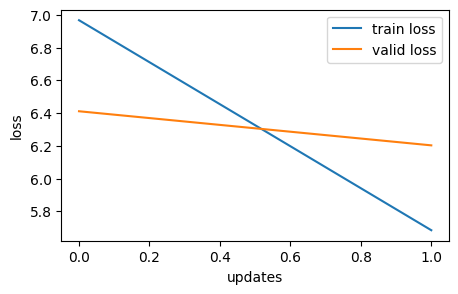

In [243]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')